In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import arviz as az
import pytensor.tensor as pt
import pymc as pm
import pytensor

from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.utils.constants import ALL_STATE_AUX_DIM, ALL_STATE_DIM
from pymc_extras.statespace.models.DFM import BayesianDynamicFactor

# Introduction  

This notebook implements a **Dynamic Factor Model (DFM)** to construct a macroeconomic coincident index, capturing the common component of the *business cycle*. The implementation is inspired by the [Statsmodels example](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html) and leverages the `pymc_extras.statespace` package for building the DFM.  


# Data  

We will use a dataset of four key macroeconomic variables from the [FRED database](https://fred.stlouisfed.org/):  

- **Industrial Production** (`IPMAN`)  
- **Real Aggregate Income** (excluding transfer payments, `W875RX1`)  
- **Manufacturing and Trade Sales** (`CMRMTSPL`)  
- **Employees on Non-Farm Payrolls** (`PAYEMS`)  

In [2]:
# Download the data
# Series: INDPRO, PAYEMS, MANEMP, and RRSFS
# Monthly data from 1959-01 to 2020-12
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2014, 12, 31)

indprod = DataReader("IPMAN", "fred", start=start, end=end)
income = DataReader("W875RX1", "fred", start=start, end=end)
sales = DataReader("CMRMTSPL", "fred", start=start, end=end)
emp = DataReader("PAYEMS", "fred", start=start, end=end)

data = pd.concat((indprod, income, sales, emp), axis=1)
data.columns = ["indprod", "income", "sales", "emp"]
data.index.freq = data.index.inferred_freq

print(data.head())

            indprod  income       sales    emp
DATE                                          
1979-01-01  47.1722  5248.7  561382.192  88808
1979-02-01  47.3093  5278.5  558729.039  89055
1979-03-01  47.5389  5294.3  574897.892  89479
1979-04-01  46.7402  5242.7  559387.521  89417
1979-05-01  47.3949  5227.5  571771.305  89789


### Plotting the time series
The plot below clearly shows that the time series are not stationary; the **Augmented Dickey-Fuller (ADF) test** (here omitted for brevity) confirmed our visual intuitions. 
To address this, we should apply appropriate transformations to achieve stationarity before modeling.

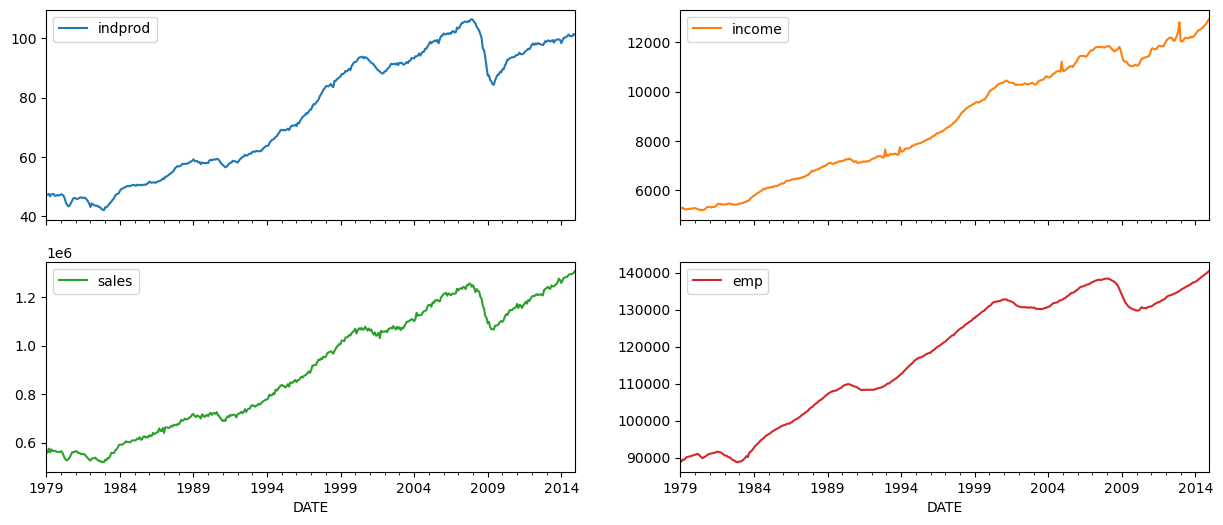

In [3]:
data.loc[:, "indprod":"emp"].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

## Stationarity Analysis and Data Transformation
Applying Log-Differencing and Standardization

In [4]:
# Create log-differenced series
data["dln_indprod"] = (np.log(data.indprod)).diff() * 100
data["dln_income"] = (np.log(data.income)).diff() * 100
data["dln_sales"] = (np.log(data.sales)).diff() * 100
data["dln_emp"] = (np.log(data.emp)).diff() * 100

# De-mean and standardize
data["std_indprod"] = (data["dln_indprod"] - data["dln_indprod"].mean()) / data["dln_indprod"].std()
data["std_income"] = (data["dln_income"] - data["dln_income"].mean()) / data["dln_income"].std()
data["std_sales"] = (data["dln_sales"] - data["dln_sales"].mean()) / data["dln_sales"].std()
data["std_emp"] = (data["dln_emp"] - data["dln_emp"].mean()) / data["dln_emp"].std()

In [5]:
# Get the endogenous data
endog = data.loc["1979-02-01":, "std_indprod":"std_emp"]

As noted in the reference notebook, following the findings of *Stock and Watson (1991)*, stationarity can be achieved by applying a **log transformation** to the series and then taking their **first differences**.  


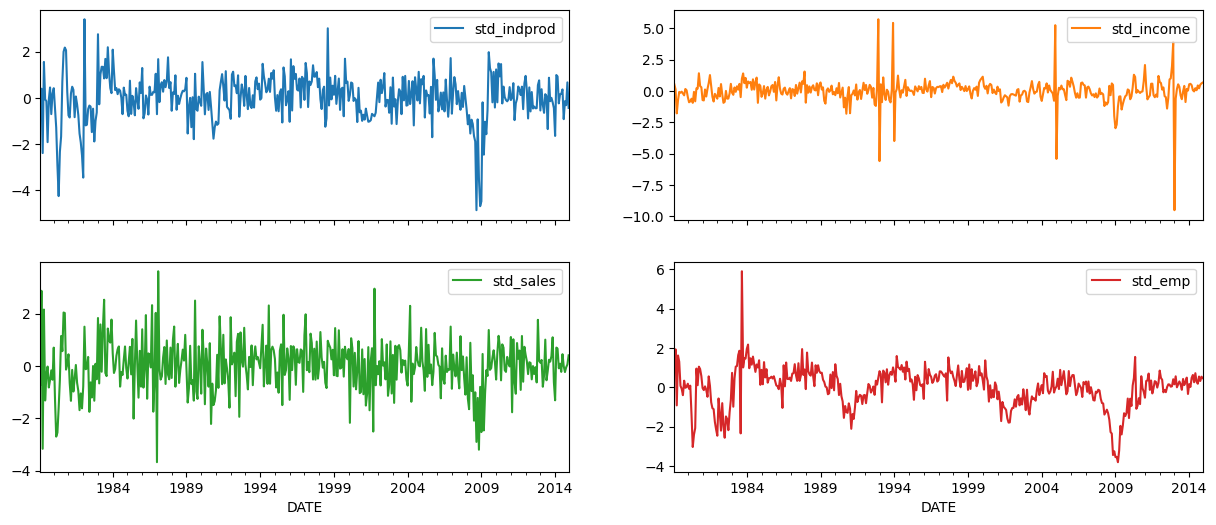

In [6]:
endog.loc[:, "std_indprod":"std_emp"].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

The transformed time series now appear standardized and **stationary**. Notably, the standardized Income series exhibits particularly large spikes. All series display **substantial volatility**, which may correspond to periods of **financial stress** (for instance, the 2008–2009 financial crisis).

### Augmented Dickey-Fuller (ADF) test for stationarity

In [7]:
def make_var_names(var, n_lags, reg):
    names = [f"L1.{var}"]
    for lag in range(1, n_lags + 1):
        names.append(f"D{lag}L1.{var}")
    if reg != "n":
        names.append("Constant")
    if "t" in reg:
        names.append("Trend")

    return names

In [8]:
def ADF_test_summary(df, maxlag=None, autolag="BIC", missing="error"):
    if missing == "error":
        if df.isna().any().any():
            raise ValueError(
                "df has missing data; handle it or pass missing='drop' to automatically drop it."
            )

    if isinstance(df, pd.Series):
        df = df.to_frame()

    for series in df.columns:
        data = df[series].copy()
        if missing == "drop":
            data.dropna(inplace=True)

        print(series.center(110))
        print(("=" * 110))
        line = (
            "Specification"
            + " " * 15
            + "Coeff"
            + " " * 10
            + "Statistic"
            + " " * 5
            + "P-value"
            + " " * 6
            + "Lags"
            + " " * 6
            + "1%"
        )
        line += " " * 10 + "5%" + " " * 8 + "10%"
        print(line)
        print(("-" * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(
            zip(["Constant and Trend", "Constant Only", "No Constant"], ["ct", "c", "n"])
        ):
            stat, p, crit, regresult = sm.tsa.adfuller(
                data, regression=reg, regresults=True, maxlag=maxlag, autolag=autolag
            )
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)

In [9]:
ADF_test_summary(endog)

                                                 std_indprod                                                  
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.429         -7.347        0.000          2    -3.980      -3.421     -3.133
	Constant             0.047          0.544        0.587
	Trend               -0.000         -0.567        0.571
Constant Only               -0.427         -7.334        0.000          2    -3.446      -2.868     -2.570
	Constant             0.005          0.105        0.916
No Constant                 -0.427         -7.342        0.000          2    -2.571      -1.942     -1.616
                                                  std_income                                                  
Specification               Coeff          Statistic     P-value      La

As we could imagine, by looking at the low level of p-values, the transformed variables are stationary

## Statsmodel


### Model specification

In this application, we consider a **dynamic factor model** with a single latent factor.  
The factor is assumed to follow an **AR(2)** process. Each observed series has its own error term, modeled as an **independent AR(2)** process. The innovations driving the factor and the errors are assumed to be mutually independent, so the covariance structure is diagonal.

Formally, the model is:

$$
y_{i,t} = \lambda_i f_t + u_{i,t}
$$

$$
u_{i,t} = c_{i,1} u_{i,t-1} + c_{i,2} u_{i,t-2} + \varepsilon_{i,t}
$$

$$
f_t = a_1 f_{t-1} + a_2 f_{t-2} + \eta_t
$$

$$
\varepsilon_{i,t} \sim \mathcal{N}(0, \sigma_i^2), \qquad 
\eta_t \sim \mathcal{N}(0, I)
$$

where \(i\) is one of: `[indprod, income, sales, emp]`.


---

This setup can be represented using the `DynamicFactor` class from **statsmodels** with the following configuration:

- `k_factors = 1` — one unobserved dynamic factor  
- `factor_order = 2` — the latent factor follows an AR(2)  
- `error_order = 2` — idiosyncratic errors are AR(2)  
- `error_var = False` — errors are treated separately rather than as a VAR (default setting)  
- `error_cov_type = 'diagonal'` — innovations are uncorrelated across series (also the default)  

---

After specifying the model, the unknown parameters are estimated by **maximum likelihood**, using the `.fit()` method.



In [10]:
# Fit the Dynamic Factor Model
mod = DynamicFactor(
    endog, k_factors=1, factor_order=2, error_order=2, error_var=False, error_cov_type="diagonal"
)
initial_res = mod.fit(method="powell", disp=False)
res = mod.fit(disp=False)
print(res.summary())

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=2)   Log Likelihood               -2050.782
                                                          + AR(2) errors   AIC                           4137.564
Date:                                                   Sat, 30 Aug 2025   BIC                           4210.754
Time:                                                           14:53:21   HQIC                          4166.462
Sample:                                                       02-01-1979                                         
                                                            - 12-01-2014                                         
Covariance Type:                                                     opg                

/opt/anaconda3/envs/pymc_extras/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The **Statsmodels estimation** raises a convergence warning: the maximum likelihood optimization did not fully converge.  
This suggests that the optimizer stopped before reaching a stable optimum, likely due to the weak identification of the model. Nevertheless, it returns an estimate that is "close enough" to a solution.  
In contrast, the Bayesian approach addresses this issue: **MCMC explores the full posterior distribution** and naturally accounts for the lack of identification.

We print the model matrices to allow for an easy comparison with the **PyMC Dynamic Factor Model (DFM)** implementation.  


In [11]:
# Access the state-space representation
ssm = res.model.ssm

print("\nDesign matrix (Z):")
print(ssm["design"])

print("\nTransition matrix (T):")
print(ssm["transition"])

print("\nSelection matrix (R):")
print(ssm["selection"])

print("\nState covariance matrix (Q):")
print(ssm["state_cov"])

print("\nObservation intercept (d):")
print(ssm["obs_intercept"])

print("\nState intercept (c):")
print(ssm["state_intercept"])

print("\nObservation covariance matrix (H):")
print(ssm["obs_cov"])


Design matrix (Z):
[[-0.69536284  0.          1.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.25042682  0.          0.          1.          0.          0.
   0.          0.          0.          0.        ]
 [-0.4372834   0.          0.          0.          1.          0.
   0.          0.          0.          0.        ]
 [-0.42548075  0.          0.          0.          0.          1.
   0.          0.          0.          0.        ]]

Transition matrix (T):
[[ 0.30237198  0.36710486  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.22851633  0.          0.          0.
  -0.17556443  0.          0.          0.        ]
 [ 0.          0.          0.         -0.19801159  0.          0.
   0.         -0.10249204  0.          0.        ]
 [ 0.          0.  

### Latent factor
The **unobserved factor** is plotted below together with the **NBER recession indicators** for the U.S. economy.  
The results suggest that the factor successfully captures key features of business cycle activity.  


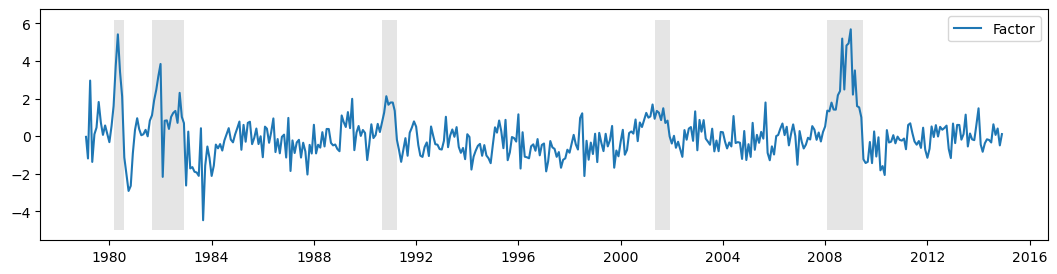

In [12]:
fig, ax = plt.subplots(figsize=(13, 3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label="Factor")
ax.legend()

# Retrieve and plot the NBER recession indicators
rec = DataReader("USREC", "fred", start=start, end=end)
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1);

A simple way to interpret the estimated factor is to **regress it on each observed variable** and record the \(R^2\) values.  
This shows which variables the factor explains well and which it does not.  

In our model with **one factor and four variables**, the factor explains most of the variation in **industrial production**, a large portion in **employment** and **sales**, and less in **income**. 

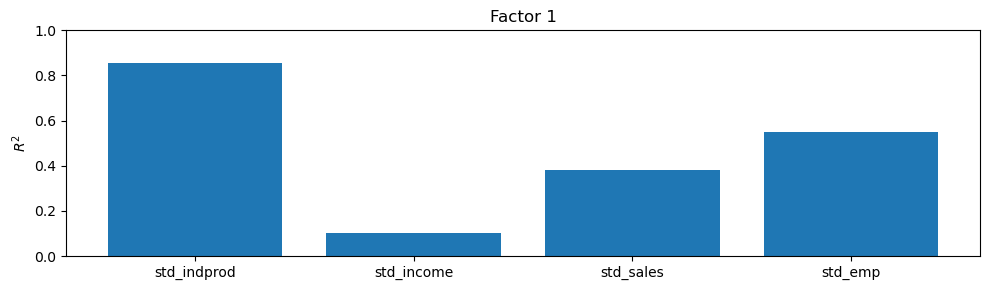

In [13]:
fig = res.plot_coefficients_of_determination(figsize=(10, 3))
ax = fig.axes[0]

var_names = res.model.endog_names

ax.set_xticks(range(len(var_names)))
ax.set_xticklabels(var_names, rotation=0, ha="center")

plt.tight_layout()
plt.show()

### US coincident (USPHCI) index as reference

As already said, the goal of this model is to construct an **interpretable coincident index** that reflects the current state of the macroeconomy.  
The index is built by reconstructing the mean of the (differenced) factor and can be compared to the **US coincident index published by the Federal Reserve Bank of Philadelphia** (USPHCI on FRED).  
For details on the methodology, see *Kim and Nelson (1999)* or *Stock and Watson (1991)*.
Below we plot this reference index (USPHCI)


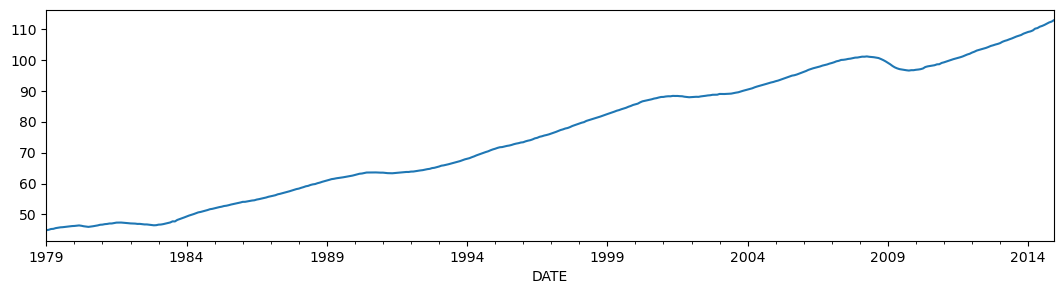

In [14]:
usphci = DataReader("USPHCI", "fred", start=start, end=end)["USPHCI"]
usphci.plot(figsize=(13, 3));

### Coincident index construction

In [15]:
dusphci = usphci.diff()[1:].values


def compute_coincident_index(mod, res):
    # Estimate W(1)
    spec = res.specification
    design = mod.ssm["design"]
    transition = mod.ssm["transition"]
    ss_kalman_gain = res.filter_results.kalman_gain[:, :, -1]

    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(
        np.eye(k_states) - np.dot(np.eye(k_states) - np.dot(ss_kalman_gain, design), transition)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = np.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())

    # Normalize the factors
    factor = res.factors.filtered[0].copy()

    factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Compute the coincident index
    coincident_index = np.zeros(mod.nobs + 1)
    # The initial value is arbitrary; here it is set to facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, mod.nobs):
        coincident_index[t + 1] = coincident_index[t] + factor[t] + factor_mean

    # Attach dates
    coincident_index = pd.Series(coincident_index, index=data.index).iloc[1:]

    # Normalize to use the same base year as USPHCI
    coincident_index *= usphci.loc["1992-07-01"] / coincident_index.loc["1992-07-01"]

    return coincident_index, factor

Below we plot the calculated coincident index along with the US recessions and the comparison coincident index USPHCI, obtaining good results in capturing the business cycle.

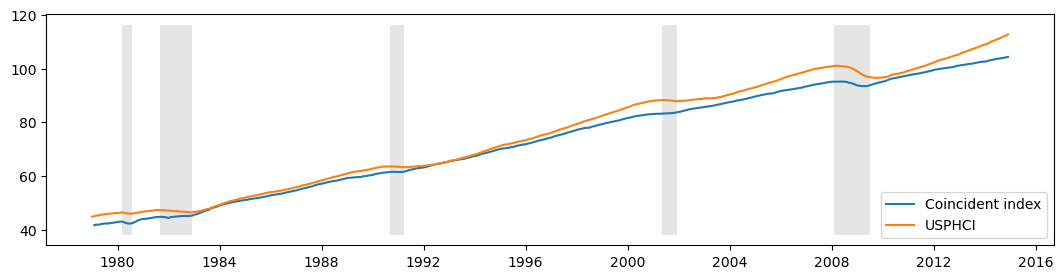

In [16]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index_res, factor_res = compute_coincident_index(mod, res)

dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index_res, label="Coincident index")
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.legend(loc="lower right")

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1);

## PyMC

We now aim to **replicate the results obtained with Statsmodels** in a **Bayesian framework** using the `BayesianDynamicFactor` model from the `pymc-extras` package.

In [17]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

### Model declaration

We define the **same model** in the Bayesian framework to ensure comparability with the Statsmodels results.  
The PyMC implementation uses the `BayesianDynamicFactor` class from `pymc_extras.statespace`.  
For details on its parameters, state-space formulation, and handling of exogenous variables, see the [full code](https://github.com/pymc-devs/pymc-extras/blob/main/pymc_extras/statespace/models/DFM.py#L1).  

This implementation allows greater flexibility than Statsmodels, particularly in integrating exogenous variables directly into the state-space representation.



In [18]:
# Initialize the model
dfm = BayesianDynamicFactor(
    k_endog=4,
    k_factors=1,
    factor_order=2,
    error_order=2,
    error_var=False,
    error_cov_type="diagonal",
    measurement_error=False,
    verbose=True,
)

                                     Model Requirements                                     
                                                                                            
  Variable          Shape      Constraints                                      Dimensions  
 ────────────────────────────────────────────────────────────────────────────────────────── 
  x0                (10,)                                                       ('state',)  
  P0                (10, 10)   Positive Semi-definite               ('state', 'state_aux')  
  factor_loadings   (4, 1)                                    ('observed_state', 'factor')  
  factor_ar         (1, 2)                                            ('factor', 'lag_ar')  
  error_ar          (4, 2)                              ('observed_state', 'error_lag_ar')  
  error_sigma       (4,)       Positive                                ('observed_state',)  
                                                                                            
  These parameters should be assigned priors inside a PyMC model block before calling the   
                               build_statespace_graph method.                               

### Setting Prior Distributions

Even with **zero-mean priors**, we can obtain robust and reliable results for the Bayesian Dynamic Factor Model.  
In the Dynamic Factor Model, the estimation of factor loadings is **only identified up to a sign**, so we use a **HalfNormal prior** to enforce positivity.


In [19]:
with pm.Model() as pymc_mod:
    # Initial state
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings vector
    factor_loadings = pm.HalfNormal("factor_loadings", sigma=0.2, shape=(4, 1))

    # AR(2) coefficients for factor f_t
    factor_ar = pm.Normal("factor_ar", mu=0.0, sigma=0.2, shape=(1, 2))

    # AR(2) coefficients for errors u_t
    error_ar = pm.Normal("error_ar", mu=0.0, sigma=0.2, shape=(4, 2))

    # Standard deviations for errors u_t
    error_sigma = pm.HalfNormal("error_sigma", sigma=0.2, shape=(4))

    # Build symbolic graph
    dfm.build_statespace_graph(data=endog, mode="JAX")

Here, we print the state-space matrices by drawing the parameters according to our prior definitions. These matrices allow for a straightforward comparison with the previously printed Statsmodels matrices.

In [20]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (10,)     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (10, 10)  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
        

The **Graphviz representation** visualizes the structure of the PyMC model, showing the **dependencies between variables and priors** and helping to understand the flow of information in the Bayesian Dynamic Factor Model.

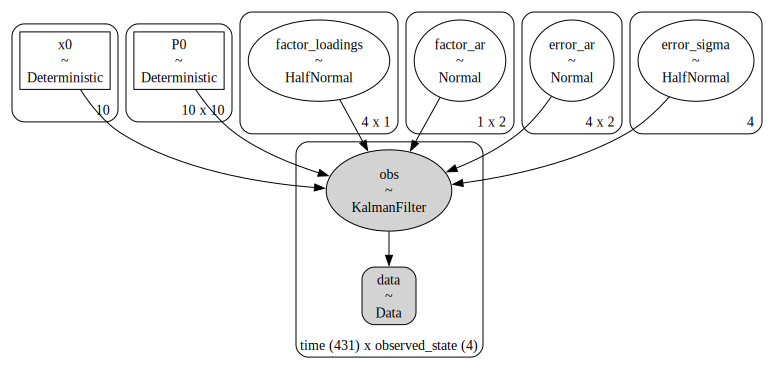

In [21]:
pymc_mod.to_graphviz()

In [ ]:
with pymc_mod:
    idata_dfm_py = pm.sample(
        draws=500,
        chains=2,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        random_seed=1,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.62,7
,1500,0,0.62,7


### Diagnostic

With the usual **energy plot**, we assess the behavior of the sampling procedure by examining the overlap between energy levels.  
Unlike optimization methods that attempt to converge to a single point estimate, **MCMC explores the entire posterior distribution**. This is particularly important in our model, which is only weakly identified: multiple parameter configurations are equally possible.

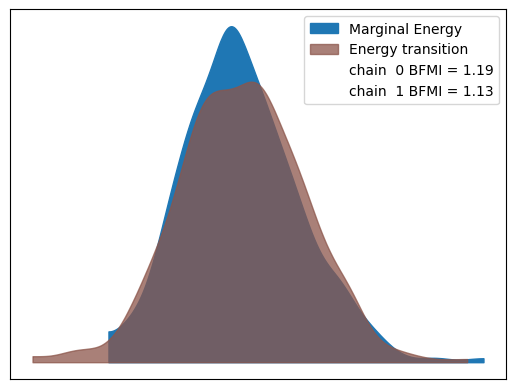

In [24]:
az.plot_energy(idata_dfm_py);

In [25]:
var_names_list_dfm_py = [name for name in dfm.param_names if name not in {"x0", "P0"}]

The **trace plot** visualizes the sampled values of each parameter over the MCMC iterations, showing a good sampling procedure for our state space model.

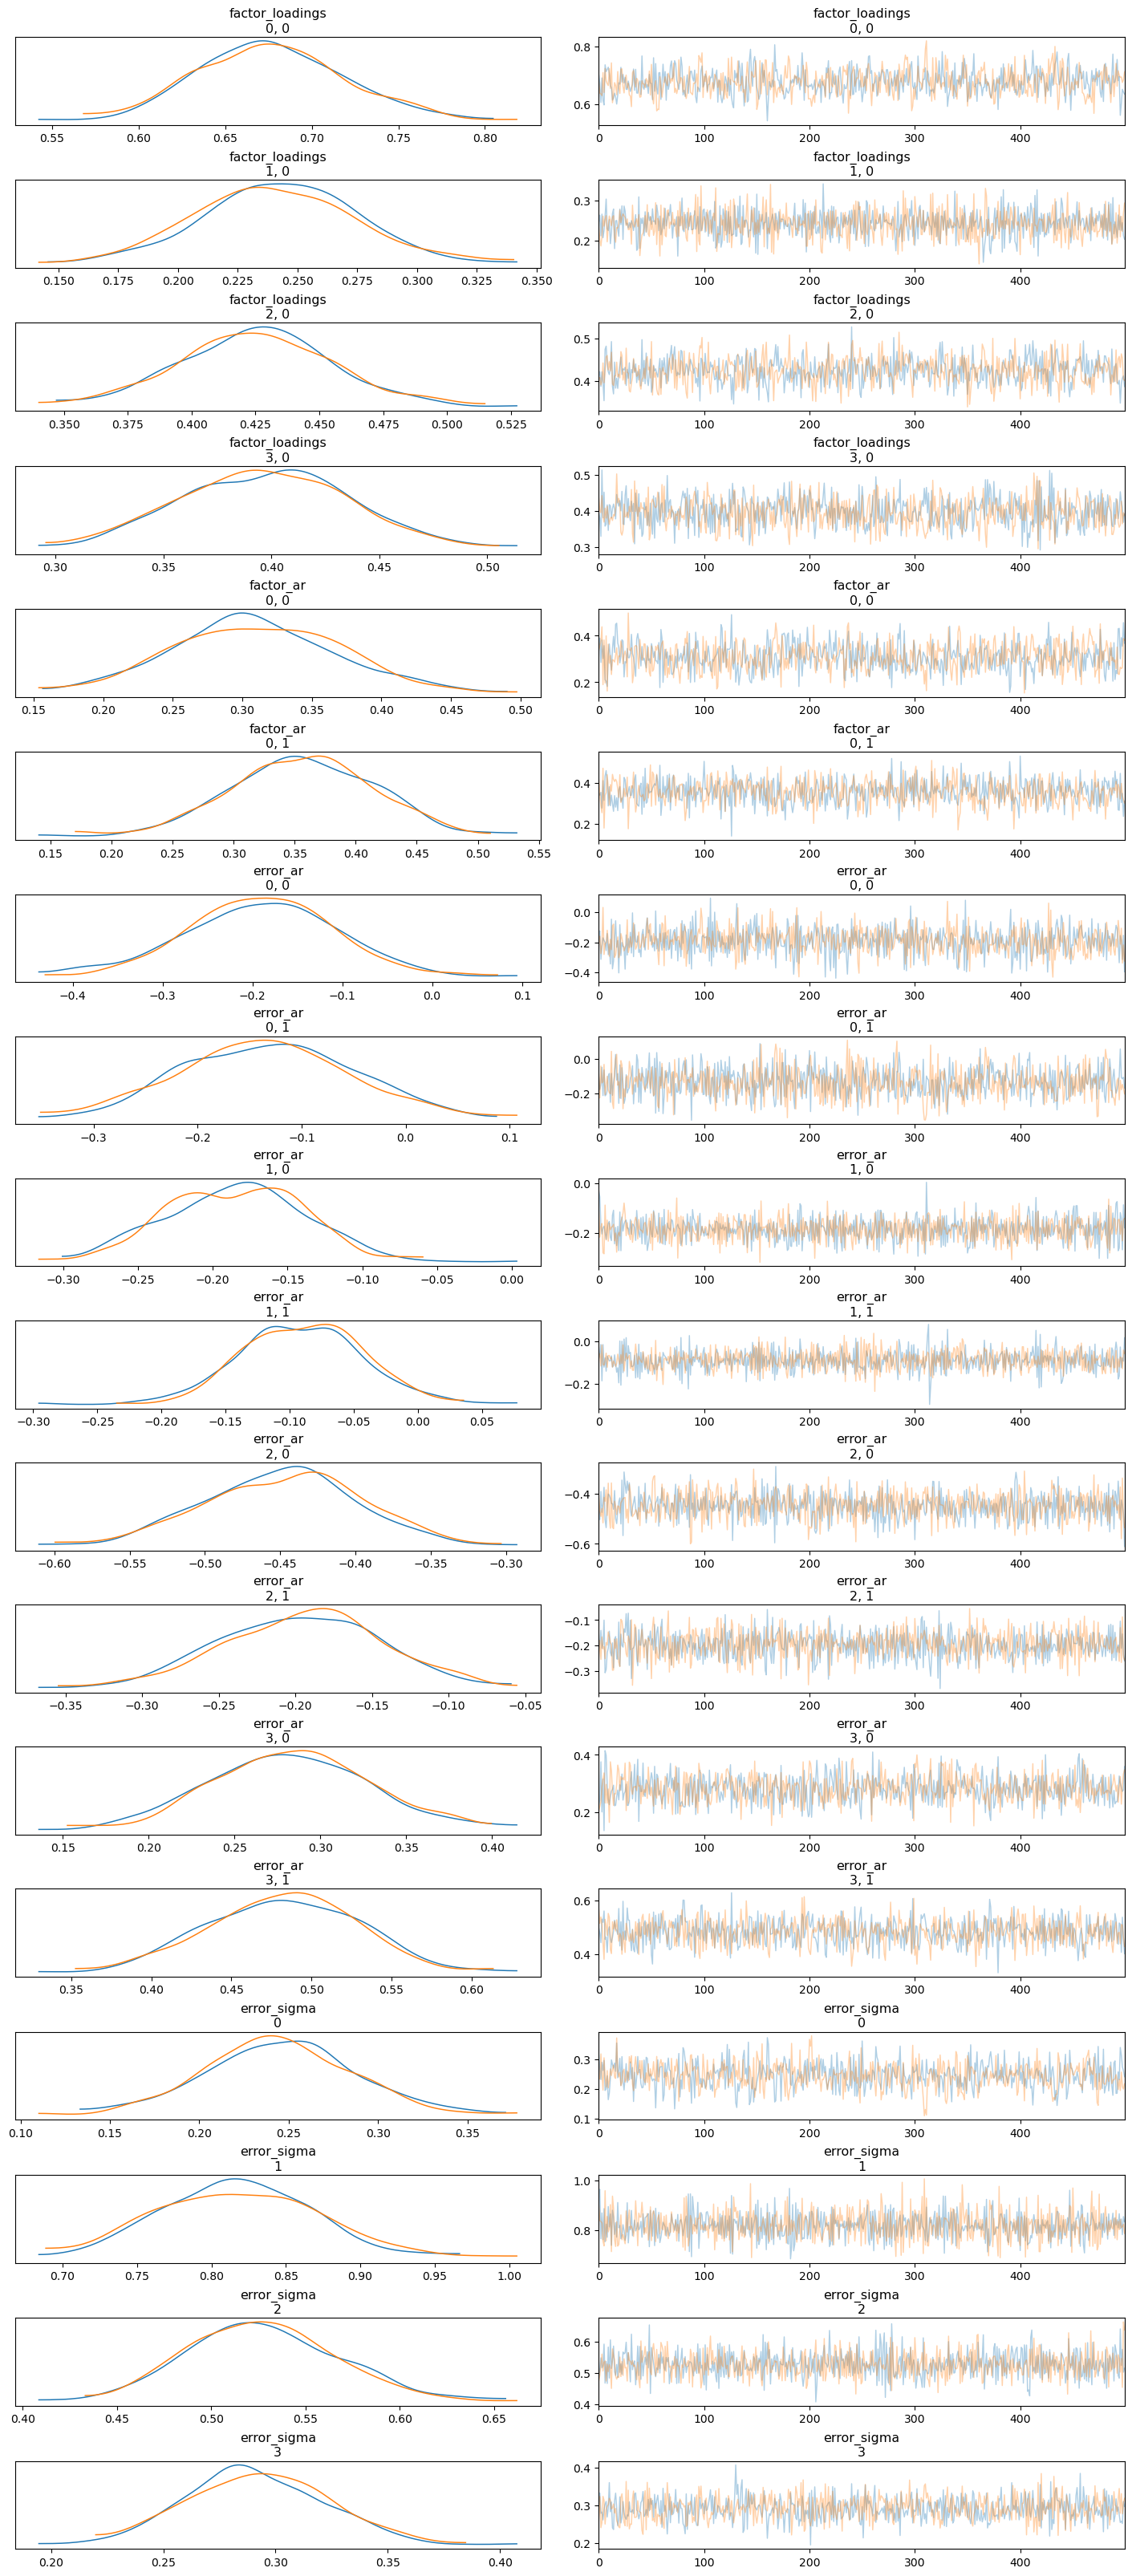

In [26]:
az.plot_trace(
    idata_dfm_py,
    var_names=var_names_list_dfm_py,
    figsize=(14, 8 * len(var_names_list_dfm_py)),
    compact=False,
)
plt.gcf().set_constrained_layout(True)
plt.show()

We compare the **posterior distributions** of the model parameters with the reference values estimated by Statsmodels.  
All reference estimates **fall within the Bayesian credible intervals**, indicating good agreement between the two approaches.


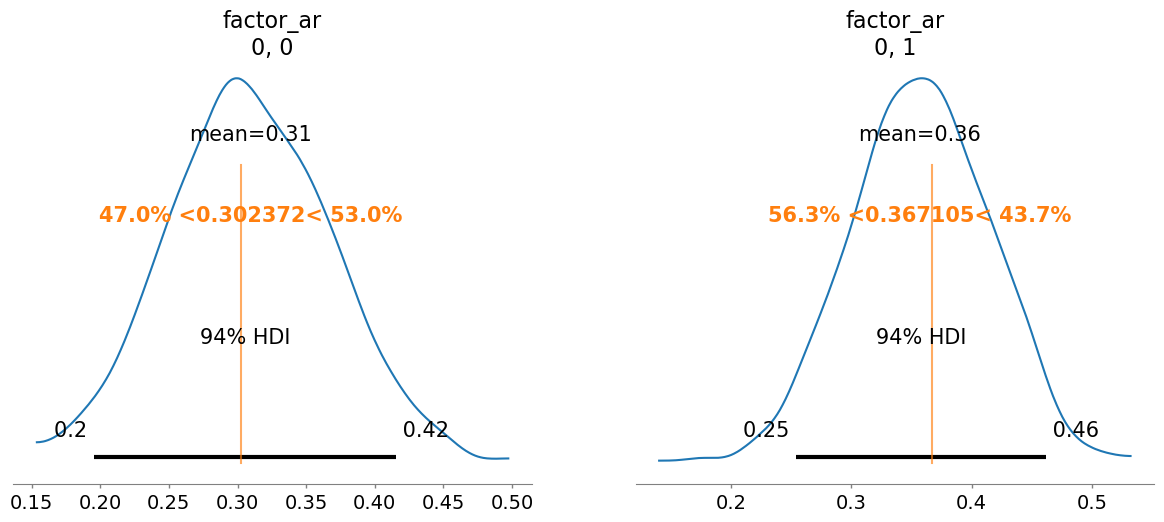

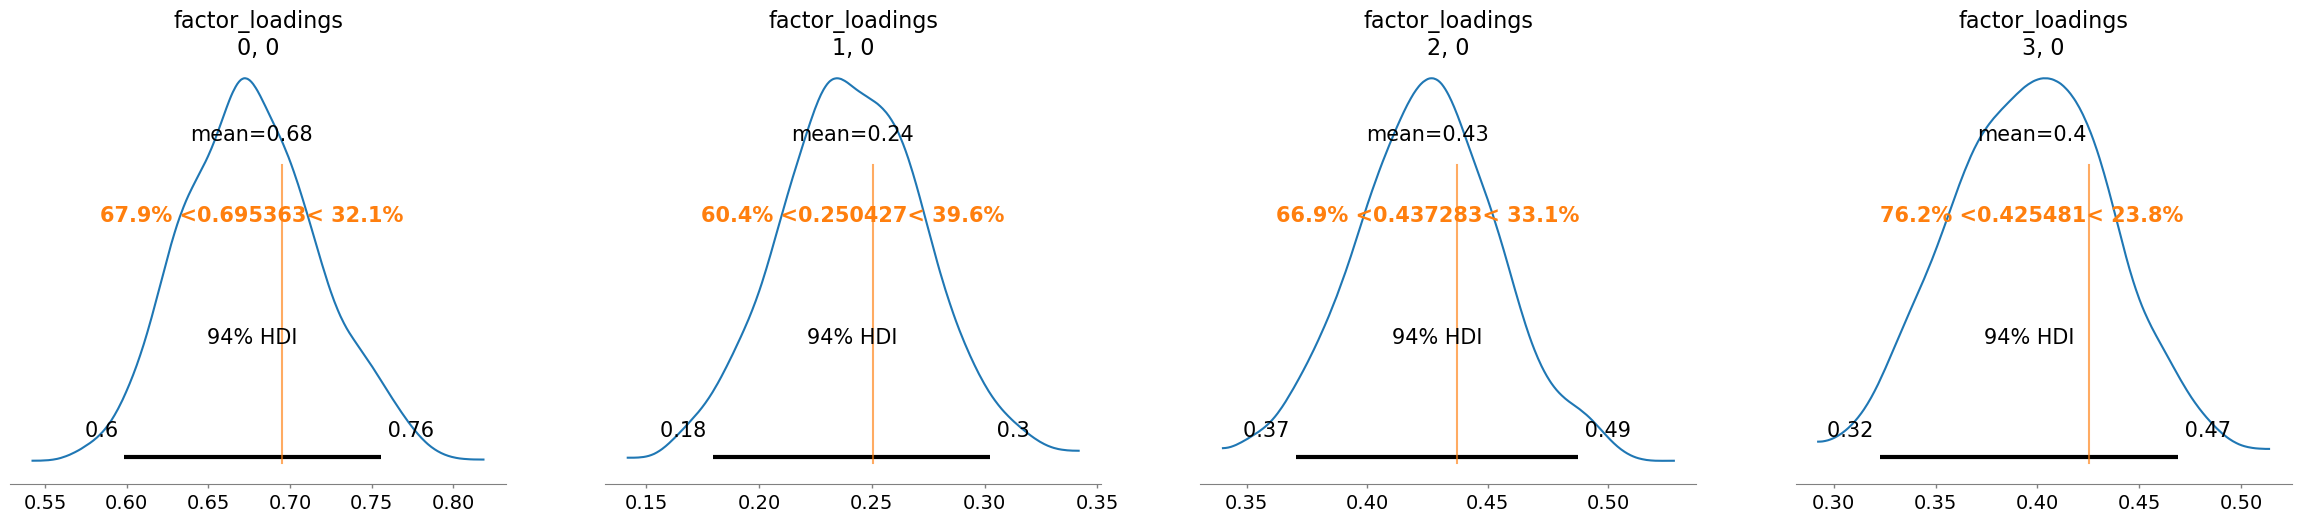

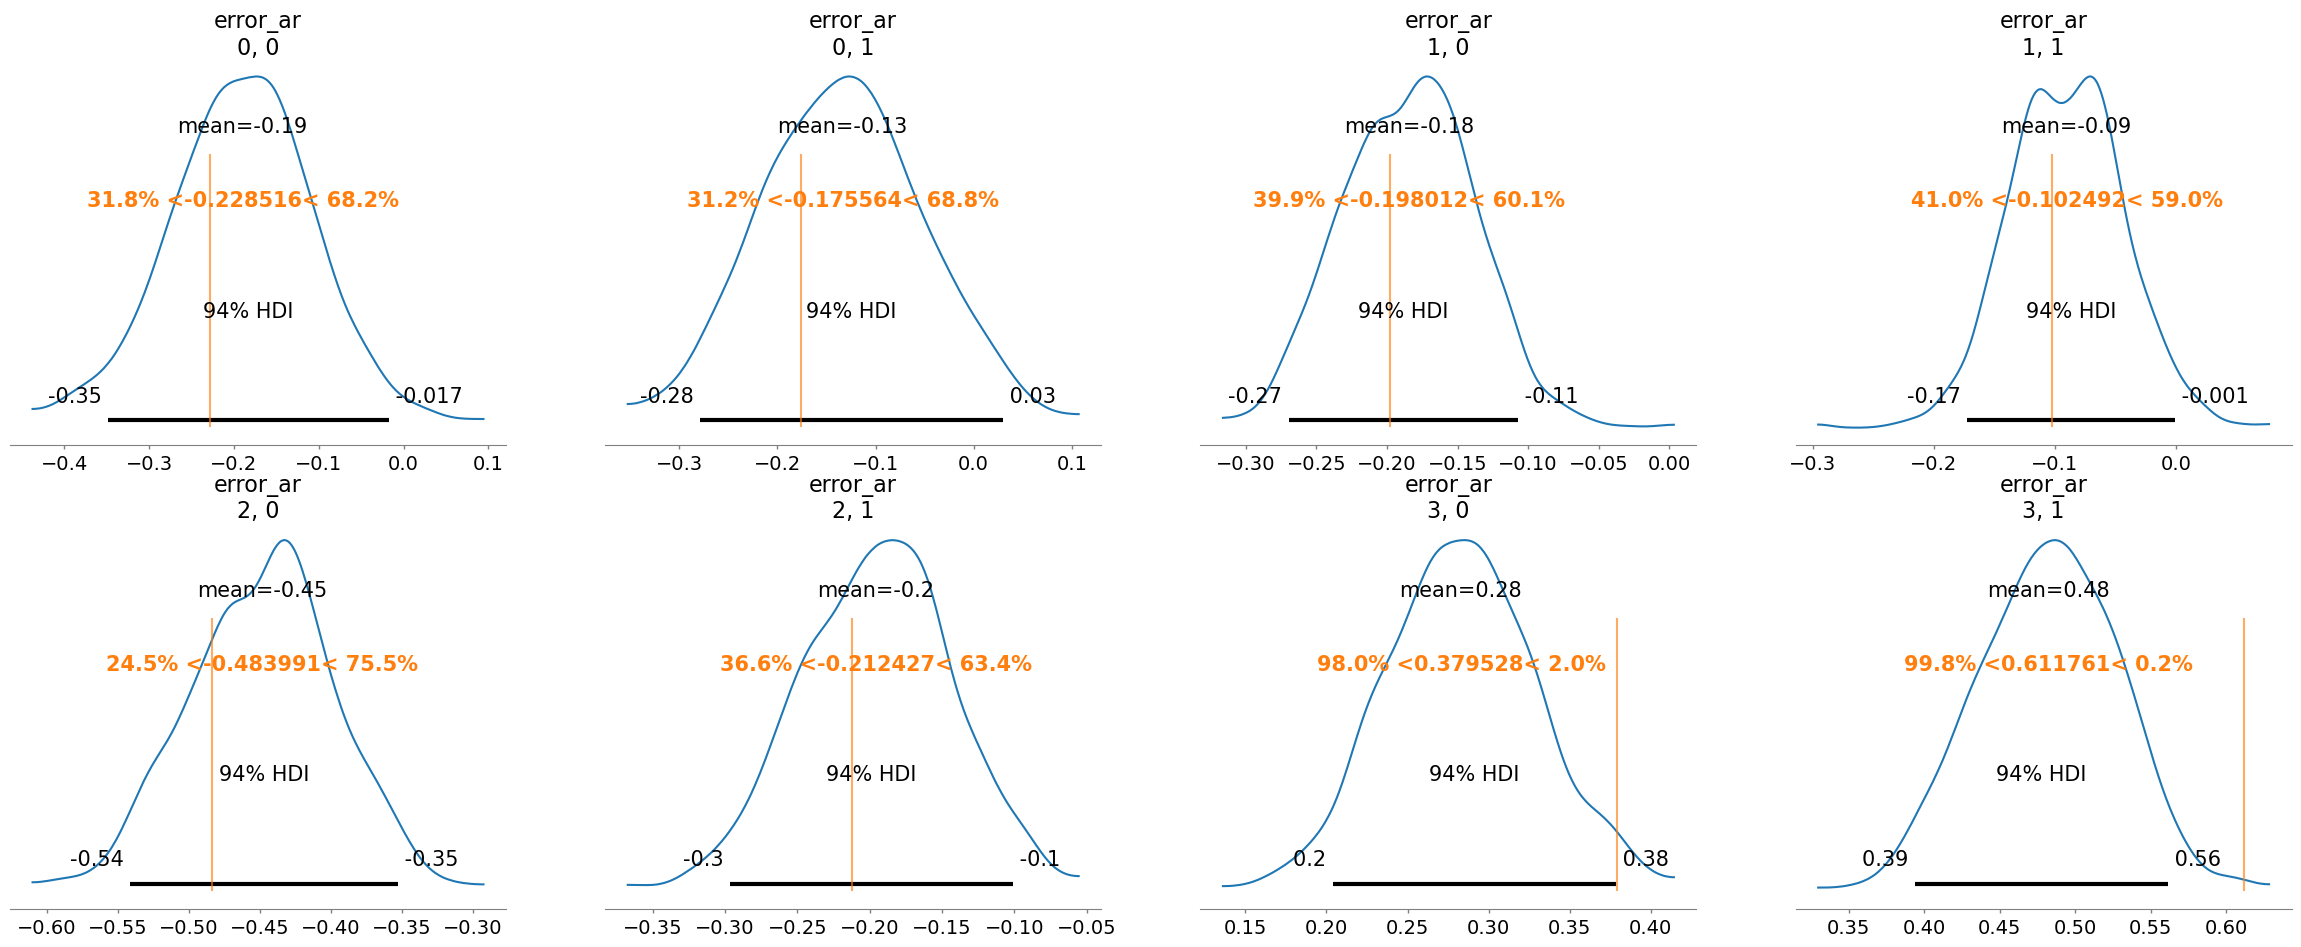

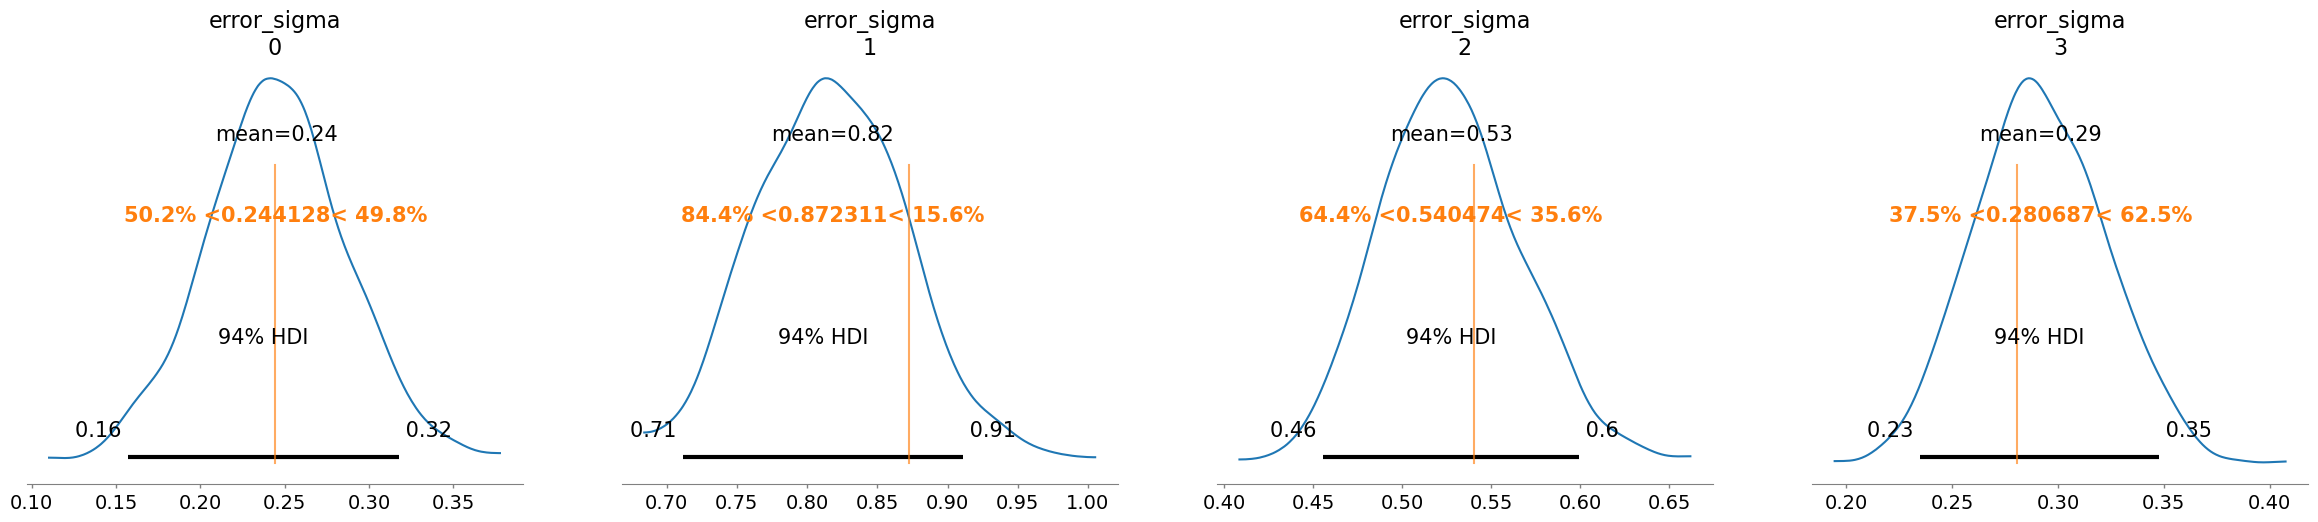

In [27]:
params = res.params.to_dict()

# Reference values map for posterior predictive checks
ref_vals = {
    "factor_ar": [params["L1.f1.f1"], params["L2.f1.f1"]],
    "factor_loadings": [
        -params["loading.f1.std_indprod"],
        -params["loading.f1.std_income"],
        -params["loading.f1.std_sales"],
        -params["loading.f1.std_emp"],
    ],
    "error_ar": [
        params["L1.e(std_indprod).e(std_indprod)"],
        params["L2.e(std_indprod).e(std_indprod)"],
        params["L1.e(std_income).e(std_income)"],
        params["L2.e(std_income).e(std_income)"],
        params["L1.e(std_sales).e(std_sales)"],
        params["L2.e(std_sales).e(std_sales)"],
        params["L1.e(std_emp).e(std_emp)"],
        params["L2.e(std_emp).e(std_emp)"],
    ],
    "error_sigma": [
        params["sigma2.std_indprod"],
        params["sigma2.std_income"],
        params["sigma2.std_sales"],
        params["sigma2.std_emp"],
    ],
}


# Helper function to plot
def plot_param_posteriors(var_name, ref_val_list):
    az.plot_posterior(idata_dfm_py, var_names=[var_name], ref_val=ref_val_list)


for var, ref in ref_vals.items():
    plot_param_posteriors(var, ref)

### Coincident index construction

In the following cells, we compute the **coincident index** in the Bayesian framework, allowing us to compare our results against the **reference USPHCI index**.  

We construct the index **symbolically** and sample its **posterior distribution**, demonstrating how Bayesian modeling provides a full distribution for derived quantities that depend on other random variables.

Key steps include:  
- **Building the state-space graph** of the `BayesianDynamicFactor` model and retrieving state space matrices.  
- **Inserting random variables** for the model parameters.  
- Passing the observed data through the **Kalman filter**, which provides **predicted covariances** and **filtered states**.  
- Computing the **Kalman gain** in a symbolic way to obtain the **factor mean vector**.  
- Scaling and normalizing the factor to match the USPHCI base year.  
- Constructing the **coincident index** as the cumulative sum of the scaled increments.  
- Sampling the **posterior predictive distribution** of both the factor and the coincident index to quantify uncertainty.  

This approach illustrates the Bayesian advantage: not only do we estimate latent factors, but we also obtain a **distribution over any quantity derived from them**, such as the coincident index, with full uncertainty propagation.


In [28]:
with pm.Model() as index_mod:
    dfm._build_dummy_graph()
    dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = dfm.unpack_statespace()

    dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariances"]
    filtered_state = index_mod["filtered_states"]

    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6

        K = pt.linalg.solve(F, PZT.T, assume_a="pos", check_finite=False).T
        return K

    ss_kalman_gain, updates = pytensor.scan(
        step, non_sequences=[Z, T, H], sequences=[predicted_covariance]
    )
    # Get the last Kalman gain (steady state)
    ss_kalman_gain = ss_kalman_gain[-1]

    k_states = T.shape[0]
    W1 = pt.linalg.inv(
        pt.eye(k_states) - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, Z), T)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())
    state_0 = filtered_state[..., 0]

    # Normalization
    normalizer = np.std(usphci.diff()[1:]) / pt.std(state_0)
    state_0_scaled = state_0 * normalizer

    # Initial value (scalar)
    initial_value = usphci.iloc[0] * factor_mean / dusphci.mean()

    # Increments: each increment is state[t] + factor_mean (broadcasted)
    increments = state_0_scaled + factor_mean

    # Cumulative sum of increments
    cumsum_increments = pt.cumsum(increments)
    coincident_index = pt.concatenate([[initial_value], initial_value + cumsum_increments])

    # Normalize to match USPHCI base year (e.g., July 1992)
    ref_idx = list(data.index).index(pd.Timestamp("1992-07-01"))
    base_value = usphci.loc["1992-07-01"]
    normalization_factor = base_value / coincident_index[ref_idx]
    coincident_index = coincident_index * normalization_factor

    filtered_state_idata_dfm_py = pm.sample_posterior_predictive(
        idata_dfm_py, var_names=["filtered_states"]
    )

    pm.Deterministic("coincident_index", coincident_index)
    coincident_index_idata_dfm_py = pm.sample_posterior_predictive(
        idata_dfm_py, var_names=["coincident_index"]
    )

Sampling: []


Output()

Sampling: []


Output()

### Obtaining latent factor

In [29]:
# Extract posterior predictive samples
state_samples_dfm_py = filtered_state_idata_dfm_py.posterior_predictive["filtered_states"].values

# Select the first state (index 0), which corresponds to the latent factor
latent_factor_dfm_py = state_samples_dfm_py[:, :, :, 0]

# Average over chains and draws to get posterior mean for each time point
latent_factor_mean_dfm_py = latent_factor_dfm_py.mean(axis=(0, 1))

# Get the time index from your observed data for x-axis
dates = filtered_state_idata_dfm_py.observed_data.time.values

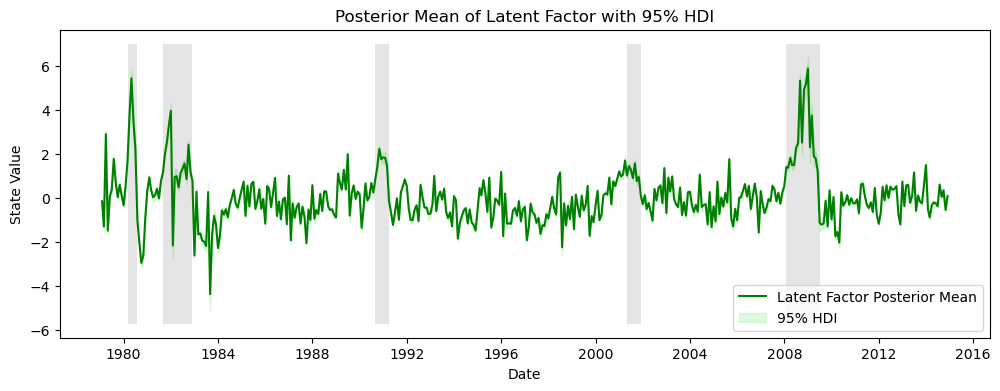

In [40]:
hdi_latent_factor_dfm_py = az.hdi(latent_factor_dfm_py, hdi_prob=0.95)
lower_latent_factor_dfm_py, upper_latent_factor_dfm_py = (
    hdi_latent_factor_dfm_py[..., 0],
    hdi_latent_factor_dfm_py[..., 1],
)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(dates, -latent_factor_mean_dfm_py, label="Latent Factor Posterior Mean", color="green")

ax.fill_between(
    dates,
    -upper_latent_factor_dfm_py,
    -lower_latent_factor_dfm_py,
    color="lightgreen",
    alpha=0.3,
    label="95% HDI",
)
# Retrieve and plot the NBER recession indicators
rec = DataReader("USREC", "fred", start=start, end=end)
ylim = ax.get_ylim()
ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("State Value")
ax.set_title("Posterior Mean of Latent Factor with 95% HDI")
ax.legend(loc="lower right")
plt.show()

### Plotting Coincident Index vs USPHCI reference index

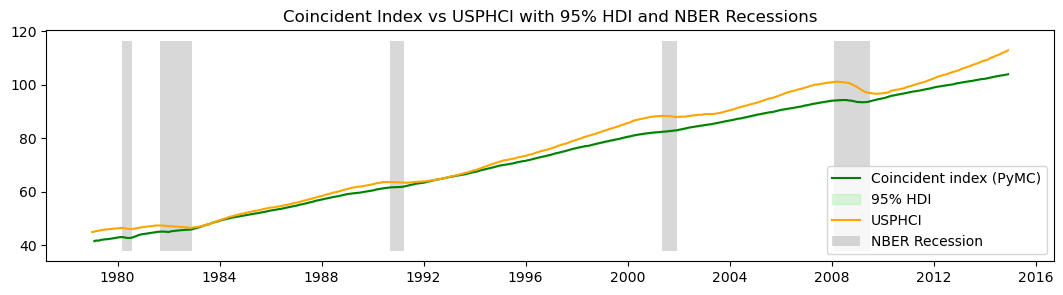

In [37]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index_pymc_samples_dfm_py = coincident_index_idata_dfm_py.posterior_predictive[
    "coincident_index"
].values
coincident_index_pymc_dfm_py = coincident_index_pymc_samples_dfm_py.mean(axis=(0, 1))

hdi_index_dfm_py = az.hdi(coincident_index_pymc_samples_dfm_py, hdi_prob=0.95)
lower_index_dfm_py, upper_index_dfm_py = hdi_index_dfm_py[..., 0], hdi_index_dfm_py[..., 1]

dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index_pymc_dfm_py[1:], label="Coincident index (PyMC)", color="green")
ax.fill_between(
    dates,
    lower_index_dfm_py[1:],
    upper_index_dfm_py[1:],
    color="lightgreen",
    alpha=0.3,
    label="95% HDI",
)
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI", color="orange")

ax.set_title("Coincident Index vs USPHCI with 95% HDI and NBER Recessions")

# Retrieve and plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(
    dates[:-3],
    ylim[0],
    ylim[1],
    where=rec.values[:-4, 0] == 1,
    facecolor="gray",
    alpha=0.3,
    label="NBER Recession",
)

ax.legend(loc="lower right")
plt.show()

Here, the HDI is so narrow relative to the scale of the plot that it is almost invisible. Nevertheless, we can clearly observe that the coincident index estimated through the Bayesian model in PyMC follows the trajectory of the USPHCI index.

## Comparison of results obtained via PyMC and Statsmodels

We are **satisfied with the results**: the Bayesian estimates closely match the classical Statsmodels outcomes.  

- The **latent factor** from PyMC aligns well with the Statsmodels factor, and the 95% credible interval captures the expected uncertainty.  
- The **coincident index** derived from the Bayesian model also shows strong agreement with both the Statsmodels index and the USPHCI reference, demonstrating that the Bayesian approach successfully reproduces the main features of the business cycle.


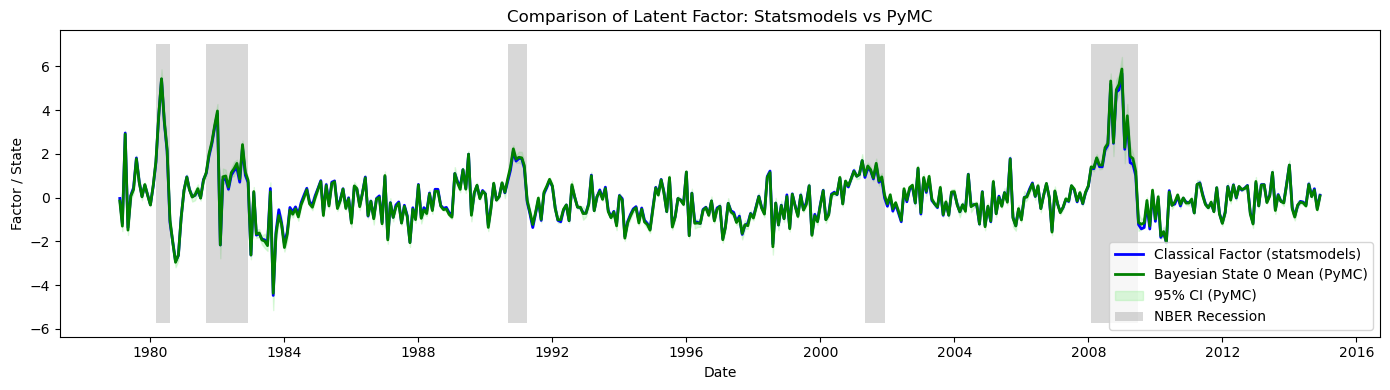

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(
    dates,
    res.factors.filtered[0],
    label="Classical Factor (statsmodels)",
    color="blue",
    linewidth=2,
)

ax.plot(
    dates,
    -latent_factor_mean_dfm_py,
    label="Bayesian Latent Factor Mean (PyMC)",
    color="green",
    linewidth=2,
)

ax.fill_between(
    dates,
    -lower_latent_factor_dfm_py,
    -upper_latent_factor_dfm_py,
    color="lightgreen",
    alpha=0.3,
    label="95% CI (PyMC)",
)
# Retrieve and plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(
    dates[:-3],
    ylim[0],
    ylim[1],
    where=rec.values[:-4, 0] == 1,
    facecolor="gray",
    alpha=0.3,
    label="NBER Recession",
)

ax.set_title("Comparison of Latent Factor: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Factor / State")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

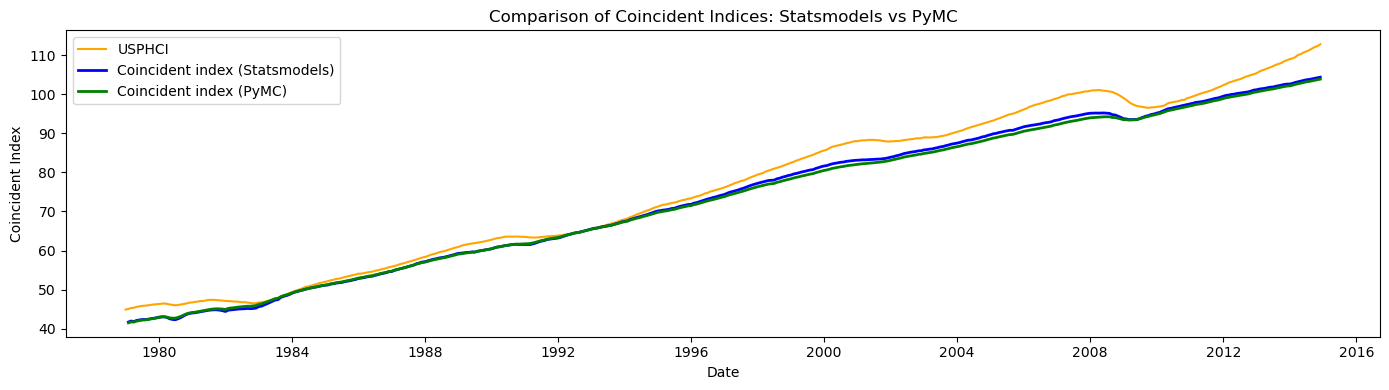

In [33]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI", color="orange")
ax.plot(
    dates, coincident_index_res, label="Coincident index (Statsmodels)", color="blue", linewidth=2
)
ax.plot(
    dates,
    coincident_index_pymc_dfm_py[1:],
    label="Coincident index (PyMC)",
    color="green",
    linewidth=2,
)

ax.legend()
ax.set_title("Comparison of Coincident Indices: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Coincident Index")
plt.tight_layout()
plt.show()